In [1]:
import warnings

import pandas as pd
import numpy as np
import sklearn
import nltk
import spacy
import re
import wandb
from datasets import load_dataset
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

warnings.filterwarnings("ignore", category=ConvergenceWarning)
wandb.errors.term._show_warnings = False

In [2]:
wandb.login()

wandb: Currently logged in as: alex-preda (lol-2). Use `wandb login --relogin` to force relogin


True

In [3]:
splitted_ds = load_dataset("dair-ai/emotion", "split")
# unsplitted_ds = load_dataset("dair-ai/emotion", "unsplit")

# df_unsplit_train = unsplitted_ds['train'].to_pandas()
df_train = splitted_ds['train'].to_pandas()
df_test = splitted_ds['test'].to_pandas()
df_validation = splitted_ds['validation'].to_pandas()

In [4]:
import gensim.downloader as api

list(api.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [5]:
ss = nltk.stem.snowball.SnowballStemmer("english")
sw = nltk.corpus.stopwords.words('english')
nlp = spacy.load('en_core_web_sm')  # english tokenizer trf -> accuracy | sm -> efficiency
word2vec = api.load("word2vec-google-news-300")  # Load the pretrained Word2Vec model
print("models imported!")

models imported!


In [6]:
def text_preparetion(sentence, nlp):
    # 1. Lowercase everything
    sentence = sentence.lower()

    # 2. Remove all symbols other than a-z@#.
    sentence = re.sub(r"[^a-zăâîșț@# ]", "", sentence)

    # # Tokenize the preprocessed sentence
    tokenization = nlp(sentence)

    # 4. Remove stopwords and empty tokens and split sentence into words
    list_text_preprocessed = [
        word.text for word in tokenization if word.text not in sw and word.pos_ != "SPACE"
    ]
    
    return ' '.join(list_text_preprocessed)


def text_vectorization_word2vec(sentence, model):
    words = sentence.split()
    words_embeddings = [model[word] for word in words if word in model]
    
    # if there are no words in the word2vec
    if not words_embeddings:
        return np.zeros(model.vector_size)
    
    # Average the word vectors to get a single sentece represenation
    return np.mean(words_embeddings, axis=0)

def text_vectorization_word2vec_weighted(sentence, model, train_tfidf_dict):
    words = sentence.split()
    words_embeddings = []
    
    for word in words:
        weight = train_tfidf_dict.get(word, 1.0)
        if word in model:
            words_embeddings.append(weight * model[word])
    
    # if there are no words in the word2vec
    if not words_embeddings:
        return np.zeros(model.vector_size)
    
    # Average the word vectors to get a single sentece represenation
    return np.mean(words_embeddings, axis=0)

tqdm.pandas()

# Preprocessing
df_train['text'] = df_train['text'].progress_apply(lambda x: text_preparetion(x, nlp))
df_test['text'] = df_test['text'].progress_apply(lambda x: text_preparetion(x, nlp))
df_validation['text'] = df_validation['text'].progress_apply(lambda x: text_preparetion(x, nlp))
print("PREPROCESSING!")

# TF-IDF
vectorizer = TfidfVectorizer()
# vectorizer = CountVectorizer()
X_train_tfidf = vectorizer.fit_transform(df_train['text'])
train_tfidf_dict = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
X_val_tfidf = vectorizer.transform(df_validation['text'])
X_test_tfidf = vectorizer.transform(df_test['text'])
print("TF-IDF!")

# word2vec
df_train['embeddings'] = df_train['text'].progress_apply(lambda x: text_vectorization_word2vec(x, word2vec))
df_test['embeddings'] = df_test['text'].progress_apply(lambda x: text_vectorization_word2vec(x, word2vec))
df_validation['embeddings'] = df_validation['text'].progress_apply(lambda x: text_vectorization_word2vec(x, word2vec))
print("WORD2VEC!")

# weighted word2vec
df_train['weighted_embeddings'] = df_train['text'].progress_apply(lambda x: text_vectorization_word2vec_weighted(x, word2vec, train_tfidf_dict))
df_test['weighted_embeddings'] = df_test['text'].progress_apply(lambda x: text_vectorization_word2vec_weighted(x, word2vec, train_tfidf_dict))
df_validation['weighted_embeddings'] = df_validation['text'].progress_apply(lambda x: text_vectorization_word2vec_weighted(x, word2vec, train_tfidf_dict))
print("WEIGHTED WORD2VEC!")
# df_unsplit_train['embeddings'] = df_unsplit_train['text'].progress_apply(lambda x: text_preparetion(x, word2vec))

100%|██████████| 2000/2000 [00:05<00:00, 341.82it/s]


PREPROCESSING!
TF-IDF!


100%|██████████| 2000/2000 [00:00<00:00, 66115.02it/s]


WORD2VEC!


100%|██████████| 2000/2000 [00:00<00:00, 41666.79it/s]


WEIGHTED WORD2VEC!


In [7]:
# save preprocessed dataset
df_train.to_csv("./data/split_train.csv", index=False)
df_test.to_csv("./data/test.csv", index=False)
df_validation.to_csv("./data/validation.csv", index=False)
# df_unsplit_train.to_csv("./data/unsplit_train.csv", index=False)

In [8]:
df_train[:100]

,text,label,embeddings,weighted_embeddings
0,nt feel humiliated,0,"[-0.19498698, 0.1408081, 0.061035156, -0.08772...","[-0.7648797, 0.81191665, 0.64800817, -0.506402..."
1,go feeling hopeless damned hopeful around some...,0,"[0.10611979, -0.01570638, 0.005818685, 0.07367...","[0.6533486, -0.23902734, 0.17611901, 0.4855068..."
2,grabbing minute post feel greedy wrong,3,"[0.045369465, 0.06301626, -0.105163574, 0.0296...","[0.41217908, 0.46653095, -0.67341155, 0.289130..."
3,ever feeling nostalgic fireplace know still pr...,2,"[0.12252372, 0.025983538, 0.008736746, 0.06814...","[0.9110772, 0.13422604, 0.13133731, 0.53929806..."
4,feeling grouchy,3,"[0.18334961, 0.21044922, -0.14233398, -0.03942...","[1.0802882, 1.1289341, -0.57756287, 0.03978543..."
...,...,...,...,...
95,feel like throwing away shitty piece shit paper,0,"[0.092681885, 0.009773254, -0.048070908, 0.111...","[0.69135594, 0.035815842, -0.21879485, 0.70745..."
96,starting feel wryly amused banal comedy errors...,1,"[0.048014324, 0.08087158, 0.0011461047, 0.0941...","[0.506407, 0.5669559, 0.09637899, 0.76437205, ..."
97,find every body beautiful want people feel vit...,1,"[0.025824653, -0.019510904, 0.05770535, 0.0679...","[0.063290104, -0.14269626, 0.4970071, 0.387071..."
98,hear owners feel victimized associations assoc...,0,"[-0.024902344, -0.024559868, 0.005533854, 0.00...","[-0.23187801, -0.25392118, 0.14278063, 0.09517..."


In [91]:
X_train = df_train['weighted_embeddings'].to_numpy()
X_train = np.vstack(X_train)

Y_train = df_train['label']

X_val = df_validation['weighted_embeddings'].to_numpy()
X_val = np.vstack(X_val)
Y_val = df_validation['label']

X_test = df_test['weighted_embeddings'].to_numpy()
X_test = np.vstack(X_test)
Y_test = df_test['label']

In [82]:
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score


def plot_silhuette(model, model_name):
    global labels, silhouette_vals, n_clusters, fig, ax, y_lower, y_upper, yticks, i, cluster, cluster_silhouette_vals, color
    labels = model.labels_
    # Filter out the noise points
    non_noise_mask = labels != -1
    X_filtered = X_train_tfidf[non_noise_mask]
    labels_filtered = labels[non_noise_mask]
    # Calculate the silhouette scores for the non-noise points
    silhouette_vals = silhouette_samples(X_filtered, labels_filtered)
    # Create the silhouette plot
    n_clusters = len(set(labels_filtered))  # Number of clusters
    fig, ax = plt.subplots(figsize=(10, 6))
    y_lower, y_upper = 0, 0
    yticks = []
    for i, cluster in enumerate(np.unique(labels_filtered)):
        cluster_silhouette_vals = silhouette_vals[labels_filtered == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        color = plt.cm.Spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        yticks.append((y_lower + y_upper) / 2)
        y_lower = y_upper
    ax.axvline(x=silhouette_score(X_filtered, labels_filtered), color="red", linestyle="--")
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.unique(labels_filtered))
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster")
    ax.set_title(f"Silhouette Plot for {model_name} Clustering")
    plt.show()

# DBSCAN

In [92]:
from sklearn.cluster import DBSCAN

param_grid = {
    'eps': [0.3, 0.5, 0.7],  # The maximum distance between two samples for them to be considered as in the same neighborhood
    'min_samples': [5, 10, 15],  # The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
}

def custom_silhouette_score(X, labels):
    # Count the number of clusters excluding noise
    num_unique_labels = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Return a very low score if there are fewer than 2 clusters
    if num_unique_labels <= 1:
        return -1  # Or return 0, depending on your scoring preferences
    
    try:
        score = silhouette_score(X, labels)
    except ValueError:
        # Handle the case where the silhouette score computation fails
        return -1
    
    return score

best_model = None
best_score = -1
best_labels = None
for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_train)
        
        # Calculate the silhouette score
        score = custom_silhouette_score(X_train, labels)
        if score > best_score:
            best_model = dbscan
            best_score = score
            best_labels = labels
        print(f"{eps=} - {min_samples=}")
        
print(f"Best Score: {best_score}")

eps=0.3 - min_samples=5
eps=0.3 - min_samples=10
eps=0.3 - min_samples=15
eps=0.5 - min_samples=5
eps=0.5 - min_samples=10
eps=0.5 - min_samples=15
eps=0.7 - min_samples=5
eps=0.7 - min_samples=10
eps=0.7 - min_samples=15
Best Score: -1


In [93]:
plot_silhuette(best_model, "DBSCAN")

AttributeError: 'NoneType' object has no attribute 'labels_'

# K-MEANS

In [94]:
from sklearn.cluster import KMeans

param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # The number of clusters to form
    'n_init': [10, 20, 30],  # The number of time the k-means algorithm will be run with different centroid seeds
}

best_model = None
best_score = -1
best_labels = None
for n_clusters in param_grid['n_clusters']:
    for n_init in param_grid['n_init']:
        kmeans = KMeans(n_clusters=n_clusters, n_init=n_init)
        labels = kmeans.fit_predict(X_train)
        
        # Calculate the silhouette score
        score = custom_silhouette_score(X_train, labels)
        if score > best_score:
            best_model = kmeans
            best_score = score
            best_labels = labels
        print(f"{n_clusters=} - {n_init=}")
print(f"Best Score: {best_score}")

n_clusters=2 - n_init=10
n_clusters=2 - n_init=20
n_clusters=2 - n_init=30
n_clusters=3 - n_init=10
n_clusters=3 - n_init=20
n_clusters=3 - n_init=30
n_clusters=4 - n_init=10
n_clusters=4 - n_init=20
n_clusters=4 - n_init=30
n_clusters=5 - n_init=10
n_clusters=5 - n_init=20
n_clusters=5 - n_init=30
n_clusters=6 - n_init=10
n_clusters=6 - n_init=20
n_clusters=6 - n_init=30
n_clusters=7 - n_init=10
n_clusters=7 - n_init=20
n_clusters=7 - n_init=30
n_clusters=8 - n_init=10
n_clusters=8 - n_init=20
n_clusters=8 - n_init=30
n_clusters=9 - n_init=10
n_clusters=9 - n_init=20
n_clusters=9 - n_init=30
n_clusters=10 - n_init=10
n_clusters=10 - n_init=20
n_clusters=10 - n_init=30
Best Score: 0.05487384647130966


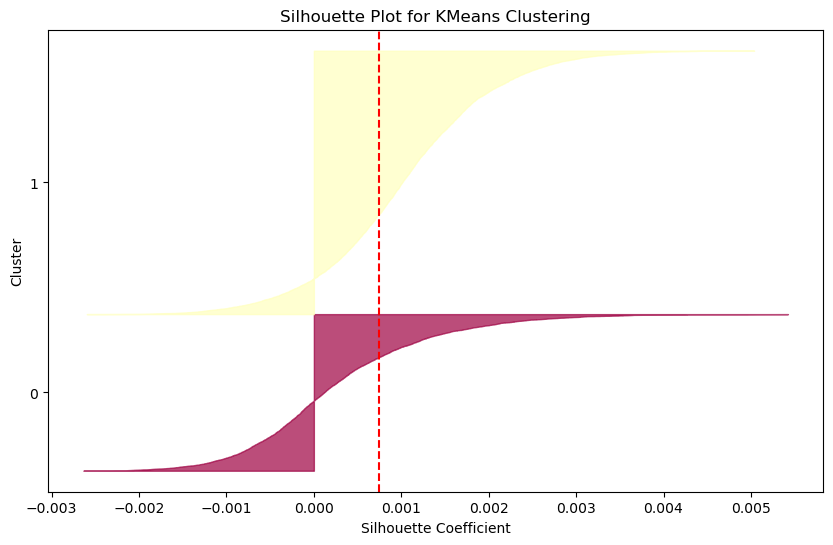

In [95]:
plot_silhuette(best_model, "KMeans")